In [1]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
from folium import IFrame
from geopy.distance import geodesic
from shapely.geometry import Point

plt.style.use("ggplot")

# Task 2.12: Historic data series

## Part B: Check outlet locations

Torstein has provided outlet locations for large wastewater and industry sites exported from Miljødirektoratet's database (see e-mails received 22.11.2023 and 23.11.2023). The dataset includes locations for all years (including sites that are no longer active), so hopefully I'll be able to match as many outlet locations as possible for the period from 2013 to 2022.

This notebook compares site and outlet locations to ensure co-ordinates are reasonable.

In [2]:
# Functions for use later
def utm_to_latlon(df):
    """Takes a dataframe with columns

        ["site_zone", "site_east", "site_north", "outlet_zone", "outlet_east", "outlet_north"]

    and adds

        ["site_lon", "'site_lat", "outlet_lon", "outlet_lat"]

    in WGS84 geographic co-ordinates.
    """
    for loc in ["site", "outlet"]:
        # Convert UTM Zone to Pandas' nullable integer data type
        # (because proj. complains about float UTM zones)
        df[f"{loc}_zone"] = df[f"{loc}_zone"].astype(pd.Int64Dtype())
        df = nivapy.spatial.utm_to_wgs84_dd(
            df, f"{loc}_zone", f"{loc}_east", f"{loc}_north"
        )
        df.rename(columns={"lat": f"{loc}_lat", "lon": f"{loc}_lon"}, inplace=True)

    return df


def geodesic_distance(df):
    """Takes a dataframe with columns

        ["site_lon", "'site_lat", "outlet_lon", "outlet_lat"]

    and calculates the distance in kilometres between points (site_lon, site_lat) and
    (outlet_lon, outlet_lat). Results are added as a new column named 'outlet_dist_km'.
    """
    df["outlet_dist_km"] = df.apply(
        lambda row: geodesic(
            (row["site_lat"], row["site_lon"]), (row["outlet_lat"], row["outlet_lon"])
        ).km,
        axis="columns",
    )

    return df


def make_map(df):
    """Takes a dataframe with columns

        ["site_lon", "'site_lat", "outlet_lon", "outlet_lat"]

    and creates an interactive map where:

        - Points at (site_lon, site_lat) are red
        - Points at (outlet_lon, outlet_lat) are blue
        - A black line links (site_lon, site_lat) and (outlet_lon, outlet_lat)
        - All points are labelled with a popup showing site details
    """
    m = folium.Map(
        location=[df["site_lat"].mean(), df["site_lon"].mean()], zoom_start=2
    )
    for idx, row in df.iterrows():
        # Create an HTML table for the popup
        popup = f"""
        <table style="width:100%">
          <tr><th>Anleggsnr</th><td>{row['anleggsnr']}</td></tr>
          <tr><th>Anleggs Navn</th><td>{row['anleggsnavn']}</td></tr>
          <tr><th>Site-Outlet distance (km)</th><td>{round(row['outlet_dist_km'])}</td></tr>
        </table>
        """
        folium.CircleMarker(
            [row["site_lat"], row["site_lon"]],
            radius=5,
            color="red",
            fill=True,
            fill_color="red",
            popup=popup,
        ).add_to(m)
        folium.CircleMarker(
            [row["outlet_lat"], row["outlet_lon"]],
            radius=5,
            color="blue",
            fill=True,
            fill_color="blue",
            popup=popup,
        ).add_to(m)
        folium.PolyLine(
            [
                (row["site_lat"], row["site_lon"]),
                (row["outlet_lat"], row["outlet_lon"]),
            ],
            color="black",
        ).add_to(m)

    return m

## 1. Read raw data

In [3]:
# Output file to create
out_xls = r"/home/jovyan/shared/common/teotil3/point_data/wastewater_industry_location_qc.xlsx"

In [4]:
# Read data from Torstein
xl_path = r"/home/jovyan/shared/common/teotil3/point_data/mdir_wastewater_industry_outlet_locs.xlsx"
ww_df = pd.read_excel(xl_path, sheet_name="wastewater")
ind_df = pd.read_excel(xl_path, sheet_name="industry")

# Standardise and combine
names_dict = {
    "Anleggsnr.": "anleggsnr",
    "Navn på anlegg": "anleggsnavn",
    "Sone (lok.)": "site_zone",
    "Øst (lok.)": "site_east",
    "Nord (lok.)": "site_north",
    "Sone (utslipp)": "outlet_zone",
    "Øst (utslipp)": "outlet_east",
    "Nord (utslipp)": "outlet_north",
}
ww_df = ww_df[list(names_dict.keys())]
ind_df = ind_df[list(names_dict.keys())]
df = pd.concat([ww_df, ind_df], axis="rows")
df.rename(columns=names_dict, inplace=True)

# Convert mixed UTM => lat/lon
df = utm_to_latlon(df)

assert df["anleggsnr"].is_unique

df.head()

,anleggsnr,anleggsnavn,site_zone,site_east,site_north,outlet_zone,outlet_east,outlet_north,site_lat,site_lon,outlet_lat,outlet_lon
0,1149.0081.01,1 Vikesjøen,32,286952.0,6562578.0,32,287327.0,6561915.0,59.148864,5.274409,59.143110,5.281596
1,1149.0116.01,1.1 Rusneset (G12-1) (Nedlagt),32,290100.0,6577000.0,32,290600.0,6577000.0,59.279677,5.315407,59.279925,5.324163
2,1149.0093.01,1.2.10 Vorråvågen-Sør (F11-6) (Nedlagt),32,289100.0,6579600.0,32,289300.0,6579700.0,59.302480,5.295360,59.303476,5.298768
3,1149.0092.01,1.2.12 Vorråvågen-Nord (F11-1) (Nedlagt),32,289000.0,6580300.0,32,289100.0,6579900.0,59.308703,5.292925,59.305168,5.295068
4,1149.0091.01,1.2.14 Vorråvågen-Nord (F11-7) (Nedlagt),32,289500.0,6580600.0,32,289600.0,6580000.0,59.311641,5.301396,59.306313,5.303733


## 2. Check locations are within Norway

First, check that locations are plausible. I will use NVE's dataset of vassdragsområder to define the outline of Norway, because it extends slightly offshore.

### 2.1. Boundary for Norway

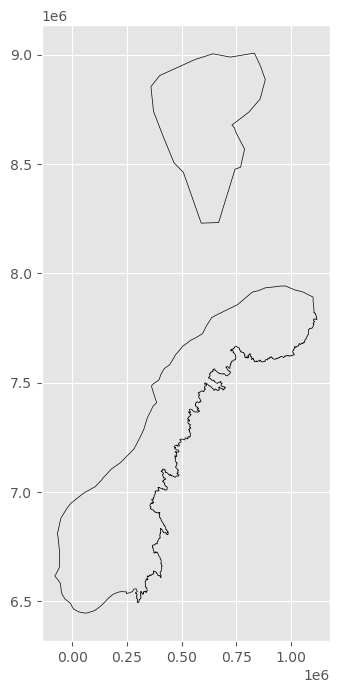

In [5]:
# Read NVE data
nve_gdb_path = "/home/jovyan/shared/common/teotil3/core_data/hydrology/NVEData.gdb"
vass_gdf = gpd.read_file(nve_gdb_path, layer="Vassdragsomr")

# Merge to single polygon
vass_gdf = vass_gdf.dissolve()

# Buffer up then down to remove small holes/slivers in NVE data
vass_gdf.geometry = vass_gdf.geometry.buffer(1000).buffer(-1000)
vass_gdf.reset_index(drop=True, inplace=True)

vass_gdf.plot(facecolor="none", edgecolor="k", figsize=(8, 8))

vass_gdf = vass_gdf.to_crs("epsg:4326")

### 2.2. Site locations outside the Norway boundary

28 sites are located outside of Norway.


,anleggsnr,anleggsnavn,site_zone,site_east,site_north,site_lat,site_lon,geometry
941,3820.0014.01,Garvikstrondi campingplass (Nedlagt),40,478680.0,315599.0,2.855283,56.808166,POINT (56.80817 2.85528)
1779,3820.0012.01,Kvambekk hytteområde (Nedlagt),40,493449.0,296892.0,2.686054,56.941064,POINT (56.94106 2.68605)
3494,3820.0013.01,Telnesøyan og Moen camping (Nedlagt),40,478460.0,317635.0,2.873703,56.806184,POINT (56.80618 2.87370)
4484,3807.0184.01,Ariana Bilpleie as,32,192266.0,6575933.0,59.210371,3.606956,POINT (3.60696 59.21037)
4509,4222.0020.01,Asfaltverk - NCC Industry - Hartevatn industri...,31,407721.0,6599776.0,59.526170,1.368754,POINT (1.36875 59.52617)


<Axes: >

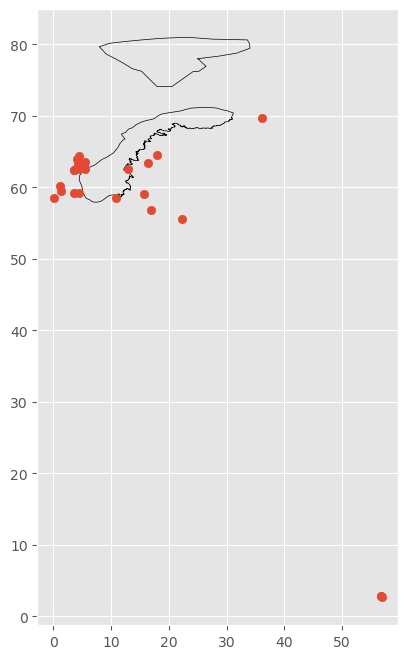

In [6]:
# Build geodataframe of site locations
site_df = df.dropna(
    subset=[
        "site_zone",
        "site_east",
        "site_north",
    ]
).reset_index(drop=True)
site_gdf = gpd.GeoDataFrame(
    site_df,
    geometry=gpd.points_from_xy(site_df.site_lon, site_df.site_lat, crs="epsg:4326"),
)

# Find sites outside Norway
sites_out_gdf = site_gdf[~site_gdf.within(vass_gdf["geometry"].iloc[0])]

# Tidy
cols = [col for col in sites_out_gdf.columns if not col.startswith("outlet")]
sites_out_gdf = sites_out_gdf[cols]

print(f"{len(sites_out_gdf)} sites are located outside of Norway.")

display(sites_out_gdf.head())

# Plot
ax = vass_gdf.plot(facecolor="none", edgecolor="k", figsize=(8, 8))
sites_out_gdf.plot(ax=ax)

### 2.3. Outlet locations outside the Norway boundary

21 outlets are located outside of Norway.


,anleggsnr,anleggsnavn,outlet_zone,outlet_east,outlet_north,outlet_lat,outlet_lon,geometry
250,1114.0008.01,Bjerkreim (Nedlagt),32,330100.0,6467400.0,58.314628,6.099625,POINT (6.09963 58.31463)
529,4614.0105.01,Djupevikneset,32,668186.0,1.0,0.000009,10.511269,POINT (10.51127 0.00001)
1634,5052.0002.01,Klongmo avløpsanlegg (Nedlagt),32,626400.0,6519400.0,58.795991,11.187408,POINT (11.18741 58.79599)
2568,3825.0031.01,Rauland Camping (Nedlagt),32,444400.0,6220500.0,56.126328,8.105581,POINT (8.10558 56.12633)
3341,4614.0104.01,Sæverhagen 2,32,668185.0,0.0,0.000000,10.511260,POINT (10.51126 0.00000)


<Axes: >

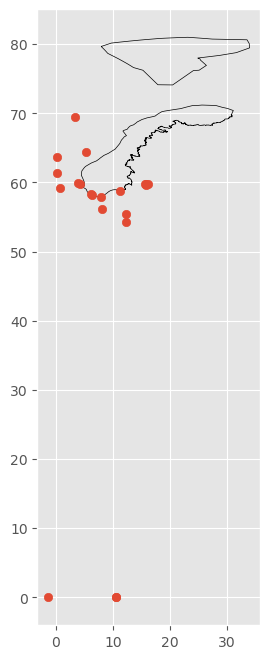

In [7]:
# Build geodataframe of outlet locations
outlet_df = df.dropna(
    subset=[
        "outlet_zone",
        "outlet_east",
        "outlet_north",
    ]
).reset_index(drop=True)
outlet_gdf = gpd.GeoDataFrame(
    outlet_df,
    geometry=gpd.points_from_xy(
        outlet_df.outlet_lon, outlet_df.outlet_lat, crs="epsg:4326"
    ),
)

# Find outlets outside Norway
outlets_out_gdf = outlet_gdf[~outlet_gdf.within(vass_gdf["geometry"].iloc[0])]

# Tidy
cols = [col for col in outlets_out_gdf.columns if not col.startswith("site")]
outlets_out_gdf = outlets_out_gdf[cols]

print(f"{len(outlets_out_gdf)} outlets are located outside of Norway.")

display(outlets_out_gdf.head())

# Plot
ax = vass_gdf.plot(facecolor="none", edgecolor="k", figsize=(8, 8))
outlets_out_gdf.plot(ax=ax)

## 3. Site-outlet relationships

Check distances between sites and outlets.

In [8]:
# Drop rows with missing spatial info
df.dropna(
    subset=[
        "site_lon",
        "site_lat",
        "outlet_lon",
        "outlet_lat",
    ],
    inplace=True,
)

# Calculate (geodesic) distance between each site and its outlet
df = geodesic_distance(df)

# Sort by distance
df.sort_values("outlet_dist_km", ascending=False, inplace=True)

df.head()

,anleggsnr,anleggsnavn,site_zone,site_east,site_north,outlet_zone,outlet_east,outlet_north,site_lat,site_lon,outlet_lat,outlet_lon,outlet_dist_km
4805,3026.0003.01,Stenqvist avd. Flexo,32,635952.0,6646300.0,31,0.0,0.0,59.931671,11.432740,0.000000,-1.488744,6740.072903
3461,4614.0104.01,Sæverhagen 2,32,305188.0,6634189.0,32,668185.0,0.0,59.799517,5.527282,0.000000,10.511260,6645.839542
540,4614.0105.01,Djupevikneset,32,304191.0,6631858.0,32,668186.0,1.0,59.778154,5.511732,0.000009,10.511269,6643.558834
4249,5060.0160.01,Rørvik Lufthavn,32,601709.0,7192252.0,33,328464.0,6015972.0,64.839157,11.144269,54.262883,12.366195,1180.198537
1674,5037.0020.01,Halsan pukkverk,32,614550.0,7066591.0,33,326803.0,6143557.0,63.708328,11.318207,55.407616,12.264297,926.250486


In [9]:
df["outlet_dist_km"].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

count    5095.000000
mean        6.533400
std       165.529241
min         0.000000
1%          0.000000
5%          0.000000
25%         0.044840
50%         0.131866
75%         0.309080
95%         1.220411
99%        14.184468
max      6740.072903
Name: outlet_dist_km, dtype: float64

I do not know what a reasonable maximum distance between a site and its outlet should be. However, the 95th percentile in the dataset is 1.2 km, so anything much larger than this is certainly unusual. Looking briefly at the "avløp" layer in Vannmiljø, the longest genuine transfer I can see is about 4 km (Kirkebygda sentralrenseanlegg, which discharges to Øyeren). I therefore think **a threshold of about 5 km is reasonable to highlight sites for further checking**.

In [10]:
dist_thresh = 5  # km
check_df = df.query("outlet_dist_km > @dist_thresh").copy()
print(
    f"There are {len(check_df)} sites with outlets more than {dist_thresh} km from the site location."
)

# Map
print(
    "\nRed circles show sites, blue circles show outlets. Click on points for details."
)
make_map(check_df)

There are 99 sites with outlets more than 5 km from the site location.

Red circles show sites, blue circles show outlets. Click on points for details.


## 4. Save results

In [11]:
# Save
with pd.ExcelWriter(out_xls) as writer:
    sites_out_gdf.drop(columns="geometry").to_excel(
        writer, sheet_name="site_loc_issues", index=False
    )
    outlets_out_gdf.drop(columns="geometry").to_excel(
        writer, sheet_name="outlet_loc_issues", index=False
    )
    check_df.to_excel(writer, sheet_name="site_outlet_issues", index=False)